In [1]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Notebook magic
%matplotlib inline

In [2]:
# Configure variables for Transfer learning
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

In [3]:
dataset_root = "/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"

train_dir = os.path.join(dataset_root, "train")
test_dir = os.path.join(dataset_root, "valid")

In [4]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 70295 images belonging to 38 classes.


In [5]:
# Get the list of categories in training data
cats = list(train_data.class_indices.keys())
cats

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [6]:
plants = []
NumberOfDiseases = 0
for plant in cats:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")
# number of unique plants
print("Number of plants: {}".format(len(plants)))
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Unique Plants are: 
['Apple', 'Blueberry', 'Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']
Number of plants: 14
Number of diseases: 26


In [7]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 17572 images belonging to 38 classes.


In [8]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 38)                48678     
                                                                 
Total params: 2,306,662
Trainable params: 48,678
Non-trainabl

In [10]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [11]:
# Num epochs
EPOCHS = 25

# Train model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCHS,
    steps_per_epoch=150,
    callbacks=[early_stopping_cb]
)

Epoch 1/25
150/150 [==============================] - 206s 1s/step - loss: 1.9380 - accuracy: 0.4988 - val_loss: 0.9658 - val_accuracy: 0.7641
Epoch 2/25
150/150 [==============================] - 126s 843ms/step - loss: 0.8413 - accuracy: 0.7727 - val_loss: 0.6576 - val_accuracy: 0.8175
Epoch 3/25
150/150 [==============================] - 126s 844ms/step - loss: 0.6780 - accuracy: 0.8029 - val_loss: 0.5440 - val_accuracy: 0.8443
Epoch 4/25
150/150 [==============================] - 129s 862ms/step - loss: 0.5584 - accuracy: 0.8375 - val_loss: 0.4841 - val_accuracy: 0.8566
Epoch 5/25
150/150 [==============================] - 126s 840ms/step - loss: 0.4960 - accuracy: 0.8508 - val_loss: 0.4506 - val_accuracy: 0.8660
Epoch 6/25
150/150 [==============================] - 124s 827ms/step - loss: 0.4640 - accuracy: 0.8587 - val_loss: 0.3870 - val_accuracy: 0.8844
Epoch 7/25
150/150 [==============================] - 124s 827ms/step - loss: 0.4310 - accuracy: 0.8648 - val_loss: 0.3679 - va

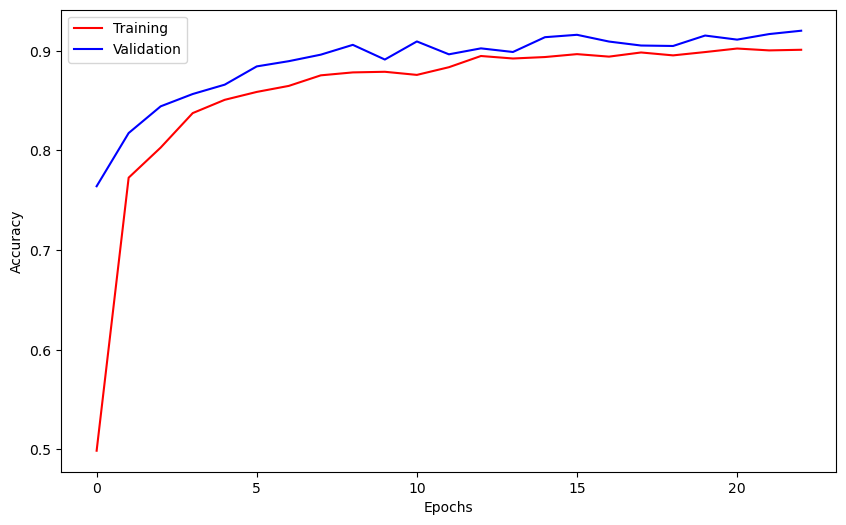

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

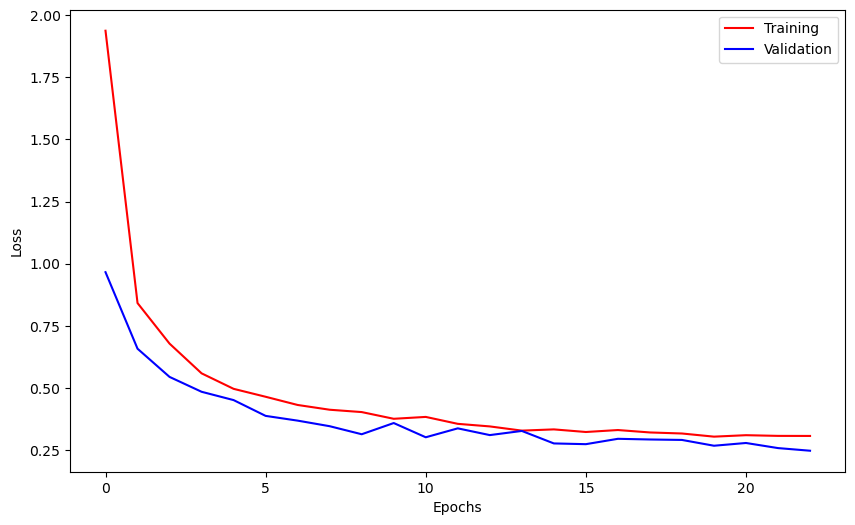

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [15]:
scores = model.evaluate(test_data)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

550/550 [==============================] - 69s 125ms/step - loss: 0.2467 - accuracy: 0.9202
loss: 24.67%


In [16]:
metrics=[
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.SpecificityAtSensitivity(0.5 ,name="spe"),
    tf.keras.metrics.SensitivityAtSpecificity(0.5 ,name="sen"),
    "accuracy"
] 

In [19]:
# model = tf.keras.models.load_model(r"/kaggle/working/Models/Model X/weights.25-1.00.tf", compile=False)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, clipvalue=0.1)
                                
model.compile(loss="categorical_crossentropy", metrics=metrics, optimizer="Adam")
evaluation = model.evaluate(test_data)
dict_metrics = {}
for i, m in enumerate(model.metrics_names):
    print(m, evaluation[i])
    dict_metrics[m] = evaluation[i]
precision  = dict_metrics["precision"]
recall = dict_metrics["recall"]

f1_score = 2 * (precision * recall) / (precision + recall)
print("f1_score ",f1_score)
dict_metrics["f1_score"] = f1_score

550/550 [==============================] - 54s 94ms/step - loss: 0.2467 - recall: 0.9003 - precision: 0.9450 - tp: 15820.0000 - tn: 649244.0000 - fn: 1752.0000 - fp: 920.0000 - spe: 1.0000 - sen: 0.9976 - accuracy: 0.9202
loss 0.24674928188323975
recall 0.9002959132194519
precision 0.945041835308075
tp 15820.0
tn 649244.0
fn 1752.0
fp 920.0
spe 0.9999769330024719
sen 0.9976098537445068
accuracy 0.9201570749282837
f1_score  0.922126372614632


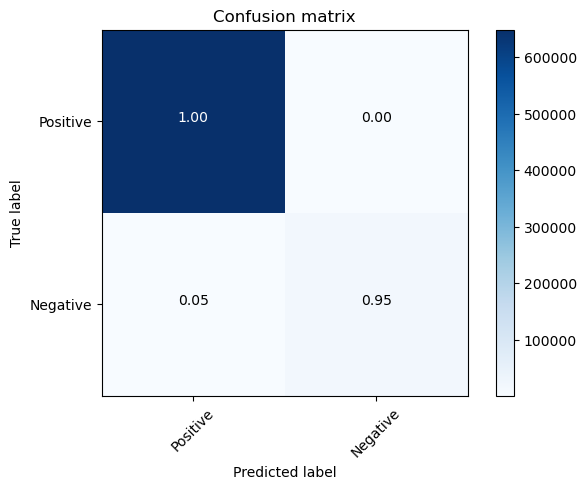

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Define true labels and predicted labels
y_true = [1]*15820 + [0]*649244 + [1]*1752 + [0]*920
y_pred = [1]*15820 + [1]*920 + [0]*649244 + [1]*1752

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define classes and colormap
classes = ['Positive', 'Negative']
cmap = plt.cm.Blues

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:.2f}".format(cm_normalized[i, j]),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Add axis labels and save the figure
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
model.save("plant_disease_detection.h5")

In [18]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)